# Hydrogenic computations

In [1]:
using JAC

┌ Info: Precompiling JAC [830ae420-d14d-11e8-2f94-6b071437414d]
└ @ Base loading.jl:1342



Welcome to JAC:  A community approach to the computation of atomic structures, cascades and time evolutions [(C) Copyright by Stephan Fritzsche, Jena (2018-2021)].


Perhaps, the simplest atomic computations can be made for hydrogenic ions. If we consider, for example, hydrogen-like argon $(Z=18)$, we can first determine and compare the energies of the $1s$ and $2p$ levels from the (non-relativistic) Schroedinger equation with those from Dirac's relativistic equation by

In [2]:
Z     = 18.0
e1s   = HydrogenicIon.energy(Shell("1s"), Z)           

  Energy for shell 1s is [in eV]: -4.40824454e+03


-162.0

In [3]:
e2p   = HydrogenicIon.energy(Shell("2p"), Z)
e2p_1 = HydrogenicIon.energy(Subshell("2p_1/2"), Z)   
e2p_3 = HydrogenicIon.energy(Subshell("2p_3/2"), Z)

  Energy for shell 2p is [in eV]: -1.10206113e+03
  Energy for subshell 2p_1/2 is [in eV]: -1.10805754e+03
  Energy for subshell 2p_3/2 is [in eV]: -1.10325210e+03


-40.54376720995463

While the (one-electron) energies are displayed by the function  `HydrogenicIon.energy()` in the default units (presently eV here and as could be overwritten by the user), all **computations are internally performed and returned always in atomic units**. This applies to all computations if not stated otherwise in the description of some particular function; indeed, the user-defined units mainly in the tabulation of results but are not *returned*. Most of these tabulations are generated by *display* method which print some table to screen but return `nothing` otherwise.

This clear distinction between the use of **atomic** and **(user-specified) default** units can be seen  easily from the output of the variables `e2p`, `e2p_1`, `e2p_3` above: 

In [4]:
(e2p, e2p_1, e2p_3) 

(-40.5, -40.720363843040175, -40.54376720995463)

The units of energies, rates and several other physical properties can be however quite easily converted among each other, for instance, by:

In [5]:
e1s_eV = convertUnits("energy: from atomic to eV", e1s)
e1s_au = convertUnits("energy: from eV to atomic", e1s_eV)
(e1s, e1s_eV, e1s_au)

(-162.0, -4408.24453524, -162.0)

... and similarly also for other energy units as well as for other physical entities; cf. `? convertUnits()`.

From these energies, we can easily compute the fine-structure splitting of the $2p$ level into the $2p_{1/2}$ and $2p_{3/2}$ (fine-structure) levels for hydrogen-like argon from above:

In [6]:
e13 = e2p_1 - e2p_3
e13_eV = convertUnits("energy: from atomic to eV", e13)

-4.805439152723064


Apart from the (single-electron) energies, we can generate also the radial orbitals, i.e. the $P(r)$ in the non-relativistic theory or  $P(r)$ and $Q(r)$  in the relativistic theory. However, the general (and analytically well-known) solutions of Dirac's equation are presently not implemented in full detail. Instead, a reasonable approximation for the Dirac orbitals is obtained by just applying the **kinetic-balance condition** to the non-relativistic $P^\mathrm{\,(nonrel)} (r)$  function and, then, by re-normalizing the large and small components ($P$ and $Q$) together. 

However, since all (radial) orbital functions are represented on some `Radial.Grid`, special care has to be taken in order to define a proper grid, and which affects also all subsequent numerical computations as well as the accuracy that can be obtained. To better understand the definition of the grid, let us ask for:

In [7]:
? Radial.Grid

`struct  Radial.Grid`  ... defines a type for the radial grid which contains all information about the grid parameters, the genration                             of the B-spline basis as well as for performing radial integrations.

```
** Physical grid parameter **
+ rnt        ::Float64           ... smalles grid point > 0.
+ h          ::Float64           ... stepsize in the construction of the exponential grid.
+ hp         ::Float64           ... asymptotic stepsize of the log-lin grid.
+ NoPoints   ::Int64             ... No. of grid points so that r[NoPoints] coincides also 
                                     with the largest break point of the B-spline knot.
** B-spline grid parameters and break points **
+ tL         ::Array{Float64,1}  ... radial break points for the B-splines of the large c.
+ tS         ::Array{Float64,1}  ... radial break points for the B-splines of the small c.
+ ntL        ::Int64             ... number of break points in the t-grid of the large c.
+ ntS        ::Int64             ... number of break points in the t-grid of the small c.
##x + nth    ::Int64             ... take each nth-point from the 'physical grid' as break point.
+ orderL     ::Int64             ... B-spline order of large components of the large c.
+ orderS     ::Int64             ... B-spline order of small components
+ nsL        ::Int64             ... number of B-splines for large components
+ nsS        ::Int64             ... number of B-splines for small components
+ orderGL    ::Int64             
    ... order of the Gauss-Lengendre integration if mesh == Radial.MeshGL(); this is also
        equal of how the break points are generated as nth-point from the physical grid points.
** Radial mesh points **
+ meshType   ::Radial.AbstractMesh
##x + nr         ::Int64         ... number of mesh points in the r-grid.
+ r          ::Array{Float64,1}  ... radial grid points
+ rp         ::Array{Float64,1}  ... derivative of the radial grid at the grid points
+ rpor       ::Array{Float64,1}  ... rp over r
+ wr         ::Array{Float64,1}  ... integration weights for all grid points, 
                                     for instance, GL weights.
```

---

`Radial.Grid()` ... constructor to define an 'empty' grid.  

---

`Radial.Grid(exponential::Bool; printout::Bool=false)`      ... constructor to define either a standard 'exponential' mesh (true) or a 'log-lin' mesh (false).          The standard mesh type is Radial.MeshGL().

---

`Radial.Grid(gr::Radial.Grid;`

```
    rnt=..,     h=..,       hp=..,      rbox=..,    orderL=..,  orderS=..,  orderGL=..,    
    meshType..,  printout=..)
... constructor for modifying the given Radial.Grid by 'overwriting' the previously selected parameters.
```


which shows the internal definition and the constructors to define such a grid. In practice, there are three (logical) levels that are considered and realized for each grid: (i) The **phenomenological grid** definition that is based on our physics understanding and intuition of which grid is appropriate to decribe a particular atomic property or process. Two currently implemented grid refers to an *exponential* grid (with exponentially increasing stepsize) as appropriate for many bound-state computations and a *linear-logarithmic* grid that start exponentially but becomes linear in its stepsize for large values of $r$. Such a *linear-logarithmic* grid is typically needed to describe electron ionization and capture processes as the incoming or outgoing electron waves are *sinusoidal* and should be represented with a proper number of grid points, say 20-30, per period of the electron wave. In JAC, the *phenomenologically* part of the grid is chosen (analogue as in GRASP) by the parameters `rnt`, `h`, `hp` and `NoPoints` in the definition above. 

(ii) The *phenomenological* definition of the grid is internally translated into a **sequence of knots** upon which the B-spline primitives are defined. Here, each `nth` mesh point from the phenomenological is chosen to keep the number of B-splines and the corresponding size of matrices (that need to be diagonalized) moderate. These knots are used to define the B-splines and to determine the eigenvectors of all orbitals (within some given potential) but they are not applied in order evaluate matrix elements or radial integrals.

(iii) The *phenomenological* grid and the definition of the B-splines (knots) are eventually combined into a **physical grid** upon which all radial functions are represented. This physical grid resembles the phenomenological grid but with modified grid points in between the *knots* of the B-spline grid
(t-grid). Here the radial points and corresponding weights are chosen due to a Gauss-Legendre distribution and goal to determine all radial integrals *exact* up to a given *Gauss-Legendre order*.

The **physical grid** is thus defined by the three arrays `r` (the mesh points along $r$), `rp` (the derivatives d `r`/ dr), `rpor` (the values rp / r) as well as `w` (the corresponding weights). All these arrays are of length `nr` $\approx$ `NoPoints` but not necessarely equal as the grid points `nr` are coupled to the underlying integration, respectively, interpolation scheme. 

In principle, this physical grid could chosen also on other *interpolation/integration* formulas, such as Gauss-Laguerre or others, that have been utilized in atomic physics. All what is needed would be to adapt the intermediate grid point and weights accordingly.

The clear distinction between the **phenomenological grid** and the **physical grid** help avoid that every new (radial) operator as well as particular boundary condition of the radial orbital functions need to be treated independently within the B-spline basis. Instead, a proper *interpolation/integration* formula should guarantee that all results are integrated sufficiently accurate, and this is first of all tested by enlarging the number of grid point `NoPoint` --> `nr`

Here, we first apply an *exponential grid*, and which is appropriate below in order to compute various expectation values:

In [8]:
grid   = Radial.Grid(true, printout= true)

Define a radial grid of type JAC.Radial.MeshGL() with 392 grid points
 [rnt=2.000e-06, h=5.000e-02, hp=0.000e+00, NoPoints=392, r_max=6.141e+02;
  B-splines with break points at every 7th point, nsL=62, nsS=63, orderL=7, orderS=8, orderGL=7,  ntL=69, ntS=71] 


Radial grid:  rnt = 2.0e-6,  h = 0.05,  hp = 0.0,  NoPoints = 392,  ntL = 69,  ntS = 71, orderL = 7,  orderS = 8,  nsL = 62,  nsS = 63,  mesh = JAC.Radial.MeshGL(), ...  
r:    [1.780504510281598e-8, 9.042759120177923e-8, 2.0787030685460475e-7]  ...  [564.4302351890452, 595.097239730825, 614.0606632064549]
wr:   [4.530145586285996e-8, 9.785739473901763e-8, 1.3358660616640612e-7]  ...  [34.882547080539766, 25.552825070730517, 11.829256033233948]
tS:   [0.0, 0.0, 0.0]  ...  [618.7099715607404, 618.7099715607404, 618.7099715607404]

With this grid, the non-relativistic radial orbitals $P(r)$ can be obtained either for a single $r$-value, for a list of $r$-values as well as for all $r$-values on a given radial grid:

In [9]:
Pnr_1s = HydrogenicIon.radialOrbital(Shell("1s"), Z, grid)
Pnr_2p = HydrogenicIon.radialOrbital(Shell("2p"), Z, grid)

392-element Vector{Float64}:
 8.895323125542194e-14
 2.2944426826828984e-12
 1.2124385701573003e-11
 3.434471347946261e-11
 6.787882523004707e-11
 1.0416489853450738e-10
 1.3047592028166753e-10
 1.4891535552172264e-10
 2.0078900763041305e-10
 3.010512642484143e-10
 4.4928933193622294e-10
 6.271045463283176e-10
 7.965299448779633e-10
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Here, the exponential tails of the radial orbitals are simply set to zero if $|P| < 1.0e-15$ (and similarly for $|Q|$).

Of course, we could plot the two functions `Pnr_1s` and `Pnr_2p` directly by some proper call of `PyPlot`, and if we give the correct arrays of radial mesh points from above. In practice, this is often quite tedious since all the specification of arrays, axes, labels, etc. need to be given explicitly. To display the shape of such orbitals, a special plotting method is prepared in JAC that displayes one or several orbitals together. This `Basics.plot` function (from the Basics module) accepts for instance a list of (relativistic) radial `Orbitals`:

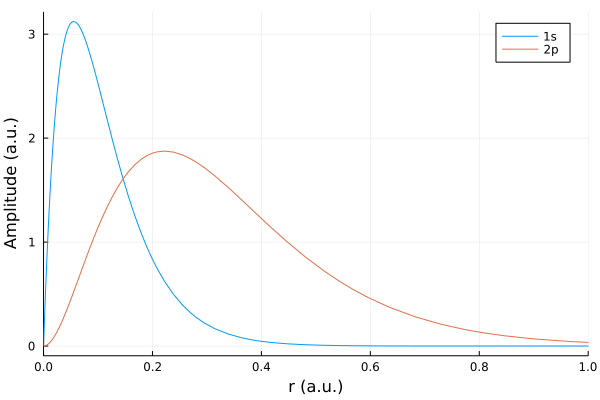

In [10]:
using Plots 
plot(grid.r, [Pnr_1s, Pnr_2p],xlims=(0,1), xlabel = "r (a.u.)", ylabel="Amplitude (a.u.)", label=["1s" "2p"])

Of course, the main purpose of plots of radial wave functions is to display and compare a number of generated orbitals, either for getting physical insight or just for test purposes. We can make use this function to visualise the relativistic orbitals if we specify the total angular momentum and generate the relativistic orbitals, which contain both the large and the small component.

In [11]:
setDefaults("standard grid", grid)
PQr_1s = HydrogenicIon.radialOrbital(Subshell("1s_1/2"), Z, grid)
PQr_2p1 = HydrogenicIon.radialOrbital(Subshell("2p_1/2"), Z, grid)
PQr_2p3 = HydrogenicIon.radialOrbital(Subshell("2p_3/2"), Z, grid)
plot(grid.r, [PQr_1s,PQr_2p1, PQr_2p3],xlims=(0,1), xlabel = "r (a.u.)", ylabel="Amplitude (a.u.)", label=["1s - Large component" "1s - Small component" "2p_1/2 - Large component" "2p_1/2 - Small component" "2p_3/2 - Large component" "2p_3/2 - Small component"])

(Re-) Define the standard grid with 392 grid points.


LoadError: UndefVarError: radialOrbital2 not defined

An alternative ...

In [12]:
? Basics.plot

`Basics.plot()`  ... plots various quantities, often in a new window.

  * `("radial potentials", potentials::Array{Radial.Potential,1}, grid::Radial.Grid; N::Int64 = 0)`     ... to plot one or more radial potentials, and where N::Int64 describes the number of grid points to be considered.       call:  using Plots; pyplot()    ... to access this method by plot(...)

---

  * `("radial orbitals: large", orbitals::Array{Radial.Orbital,1}, grid::Radial.Grid; N::Int64 = 0)`     ... to plot the large component of one or more radial orbitals, and where N::Int64 describes the number of grid        points to be considered.
  * `("radial orbitals: small", orbitals::Array{Radial.Orbital,1}, grid::Radial.Grid; N::Int64 = 0)`     ... to plot the small component of one or more radial orbitals.
  * `("radial orbitals: both",  orbitals::Array{Radial.Orbital,1}, grid::Radial.Grid; N::Int64 = 0)`     ... to plot the large and small component of one or more radial orbitals.

    call:  using Plots; pyplot()    ... to access this method by plot(...)

---

  * `("spectrum: transition rates over energy", lines::Array{PhotoEmission.Line,1})`     ... to plot the transition rates of all lines as function of their transition energies. The plot is shown in a new        window but nothing is returned otherwise. **Not yet implemented !**
  * `("spectrum: oscillator strength over energy, emission", lines::Array{PhotoEmission.Line,1})` or   `("spectrum: oscillator strength over energy, absorption", lines::Array{PhotoEmission.Line,1})`    ... to plot the absorption oscillator strength of all lines as function of their transition energies. Again, a new        window is opened but nothing returned by this method. **Not yet implemented !**

---

  * `("spectrum: transition rates over energy, Gaussian", lines::Array{PhotoEmission.Line,1}; widths=value::Float64)` or   `("spectrum: transition rates over energy, Lorentzian", lines::Array{PhotoEmission.Line,1}; widths=value::Float64)`   ... to plot the transition rates of all lines as function of their transition energies but with a Gaussian or Lorentzian        distribution. Again, a new window is opened but nothing returned by this method. It still need to be decided how        the widths (and, perhaps, other parameters) will be communicated to the method. **Not yet implemented !**


 accepts for instance a list of (relativistic) radial `Orbitals`:

In [13]:
? Orbital

search: Orbital AbstractStartOrbitals PhotoRecombination MultipolePolarizibility



`struct  Radial.Orbital`       ... defines a type for a single-electron radial orbital function with a large and small component, and which can refer to         either the standard or an explicitly given grid due to the logical flag useStandardGrid. Bound-state orbitals with energy < 0 are          distinguished from free-electron orbitals by the flag isBound.

```
+ subshell        ::Subshell          ... Relativistic subshell.
+ isBound         ::Bool              ... Logical flag to distinguish between bound (true) and free-electron orbitals (false).
+ useStandardGrid ::Bool              ... Logical flag for using the standard grid (true) or an explicitly given grid (false).
+ energy          ::Float64           ... Single-electron energies of bound orbitals are always negative.
+ P               ::Array{Float64,1}  ... Large and ..
+ Q               ::Array{Float64,1}  ... small component of the radial orbital.
+ Pprime          ::Array{Float64,1}  ... dP/dr.
+ Qprime          ::Array{Float64,1}  ... dQ/dr.
+ grid            ::Array{Float64,1}  ... explic. defined radial grid array for P, Q, if StandardGrid = false.
```

---

`Radial.Orbital(subshell::Subshell, energy::Float64)`       ... constructor for given subshell and energy, and where useStandardGrid is set to true; the grid must be defined          explicitly and neither the large and small components nor their derivatives are yet defined in this case.

---

`Radial.Orbital(label::String, energy::Float64)`       ... constructor for given string identifier and energy, and where useStandardGrid is set to true; the grid must be          defined explicitly and neither the large and small components nor their derivatives are yet defined in this case.


Of course, the main purpose of this `plot` method is to display and compared a number of generated orbitals, either for getting physical insight or just for test purposes. We can make use of the same `plot` method also for the non-relativistic  `Pnr_1s`$(r)$  orbital if we assign this array as large component of relativistic orbital and specify the additionl quantum numbers. Moreoer, we here first internally to define a standard grid as well as such an (instance of the) Orbital by using its standard constructor, and by setting the small  $Q(r)$ component as well as $dP/dr$ and $dQ/dr$ simply to zero:

In [14]:
setDefaults("standard grid", grid)
Qnr_1s   = Pprime = Qprime = zeros( length(Pnr_1s) )
nrOrb_1s = Orbital( Subshell("1s_1/2"), true, true, -162.0, Pnr_1s, Qnr_1s, Pprime, Qprime, Radial.Grid())
typeof(nrOrb_1s)

(Re-) Define the standard grid with 392 grid points.


Orbital

# **The following part of this nootebook is still under construction.**

We could also compute a relativistic $1s_{1/2}$ orbital on the given grid and plot the two $1s$-orbitals together; while the large components of these orbitals coincide of course, due to its special construction via the non-relativistic orbitals, the small compoments differ. Note that one need to use the standard REPL in order to display these functions in some separate window.

In [15]:
rOrb_1s = HydrogenicIon.radialOrbital(Subshell("1s_1/2"), Z, grid)
# JAC.plot("radial orbitals: large", Orbital[nrOrb_1s, rOrb_1s], grid; N = 230)
# JAC.plot("radial orbitals: small", Orbital[nrOrb_1s, rOrb_1s], grid; N = 230) 

LoadError: UndefVarError: radialOrbital2 not defined

We can use these orbitals to quickly evaluate some overlap integrals and $\langle r^k \rangle$ expectation values; for this, we make use of the non-relativistic $2p$ radial orbital `Pnr_2p` from above an compute the normalization  and $\langle r \rangle$ expectation values:

In [16]:
N_1s = RadialIntegrals.overlap(Pnr_1s, Pnr_1s, grid)
N_2p = RadialIntegrals.overlap(Pnr_2p, Pnr_2p, grid)

LoadError: stop a

For the sake of simplicity, all hydrogenic computations are performed for a point-like nucleus. For many-electron computations, in constrast, a more realistic nucleus can be taken into accout by selecting a proper nuclear model. See the tutorial: Define the nuclear model parameters   or   `? Nuclear.Model`  ... for further details.

In [17]:
 ? Nuclear.Model

`struct  Nuclear.Model`  ... defines a type for the nuclear model, i.e. for its form and parameters.

```
+ Z        ::Float64         ... nuclear charge
+ model    ::String          ... identifier of the nuclear model: {"Fermi", "Point", "Uniform"}
+ mass     ::Float64         ... atomic mass
+ radius   ::Float64         ... (root-mean square) radius of a uniform or Fermi-distributed nucleus
+ spinI    ::AngularJ64      ... nuclear spin I, must be >= 0
+ mu       ::Float64         ... magnetic dipole moment in Bohr magnetons
+ Q        ::Float64         ... electric quadrupole moment
```

---

`Nuclear.Model(Z::Real)`       ... to specify a Fermi-type nucleus with charge Z, and where the nuclear spin and nuclear moments are all set to zero.

---

`Nuclear.Model(Z::Real, M::Float64)`       ... to specify a Fermi-type nucleus with charge Z and mass M, and where the nuclear spin and nuclear moments are all set to zero.

---

`Nuclear.Model(Z::Real, model::String)`       ... to specify a nucleus with charge Z, model = {"Fermi", "point", "uniform"}, and where the nuclear spin and          nuclear moments are all set to zero.

---

`Nuclear.Model(nm::Nuclear.Model;`

```
        Z=..,         model=..,         mass=..,        radius=..,     
        spinI=..,     mu=..,            Q=..)
... constructor for re-defining a nuclear model nm::Nuclear.Model.
```
